**Gabriela Tanumihardja**</br>
**Capstone Project - Part V** </br>
**Re-running Models**

## Table of contents
1. [Loading data](#load)</br>
2. [Data preprocessing](#preprocess)</br>
3. [Models](#models)</br>
    3.1 [Logistic regression](#models)</br>
    3.2 [Tune C value](#cvals)</br>
    3.3 [Logit pickling](#pickle)</br>
    3.4 [PCA](#pca)</br>
    3.5 [SVM](#svm)</br>
    3.6 [Bayes](#bae)</br>
    3.7 [XGBoost](#xg)
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.feature_extraction.text import CountVectorizer
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split
import datetime as dt
import string
%matplotlib inline

***

### Loading the data
<a id='load'></a>

With the new dataset, I will refit the early models that I have previously fitted. First I will read in the sampled data, and split the data into X and y.

In [13]:
# Read in dataset

df = pd.read_csv('data/year_sampled.csv')

In [14]:
# Assign X and y

X = df['title']
y = df['satire']

In [15]:
# Check!

X.head()

0    Divorced Mom At Point In Life Where She Figure...
1     Unclear Why Only One Half Of Couple Wearing Mask
2     Jessie Fleming turns pro, signs deal with Che...
3     Full Stream Ahead: Your best action movie bet...
4     COVID-19 in Quebec: Province reports 133 new ...
Name: title, dtype: object

In [17]:
# Check!

y.head()

0    1
1    1
2    0
3    0
4    0
Name: satire, dtype: int64

I will perform a train test split on this new dataset in the same way I did previously, to remainder, validation, and test. I will stratify the split by the classes.

In [18]:
# Split dataset into remainder and test set

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size = 0.1, random_state = 99, stratify = y)

Set aside test set for the very end!

In [19]:
# Split remainder into train and validation set

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.1, random_state = 99, stratify = y_rem)

In [20]:
# Reset indices for all sets

dfs = [X_rem, X_train, X_val, X_test, y_rem, y_train, y_val, y_test]

for df in dfs:
    df.reset_index(inplace = True, drop = True)

In [21]:
# Check

X_rem.shape

(31262,)

In [22]:
# Check check!

X_test.shape

(3474,)

In [23]:
# Checkity check check!

X_rem.head(10)

0    B.C. Premier to province: ‘Some of my best fri...
1    John Kerry Costs U.S. Defense Industry $400 Bi...
2                             Nina Esaki, Sander Rabin
3          Russians’ Opinions of Moscow’s Former Mayor
4                 Bouncing and Bopping to Clubby Beats
5                        Apartment Building Super Swap
6    How To Stay Politically Active After The Election
7    Area Woman Quietly Satisfied To Have Concrete ...
8                              Closeting the Arguments
9    Lazy Poor Person Has Never Earned Passive Inco...
Name: title, dtype: object

***

### Preprocessing
<a id='preprocess'></a>

Great! All's looking good. I will now move on to preprocess my data. I will be using TF-IDF to fit the models because I think it would be good to take into consideration the frequency of the words.

In [24]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

In [26]:
# Good 'Ol Tokenizer

def my_tokenizer(sentence):
    
    t_map = defaultdict(lambda : wn.NOUN)
    t_map['J'] = wn.ADJ
    t_map['V'] = wn.VERB
    t_map['R'] = wn.ADV

    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.lower().replace(punctuation_mark,'').replace('  ' , ' ').replace('onion', '').replace('horoscope', '')
    
    sentence = re.sub('^ ', '', sentence)
    sentence = re.sub('[0-9]{5,}', '#####', sentence)
    sentence = re.sub('[0-9]{4}', '####', sentence)
    sentence = re.sub('[0-9]{3}', '###', sentence)
    sentence = re.sub('[0-9]{2}', '##', sentence)
    sentence = re.sub(' $', '', sentence)
    
    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmas = []
    
    tagged = pos_tag(listofwords)

    # Remove stopwords and any tokens that are just empty strings
    for word, tag in tagged:
        if (not word in ENGLISH_STOP_WORDS) and (word!='') and (word != ' '):
            # Turn words to lemmas
            lemma = lemmatizer.lemmatize(word, t_map[tag[0]])
            listoflemmas.append(lemma)

    return listoflemmas

I will now tranform my data through the TF-IDF vectorizer. I will keep the min_df setting at 10 words, and of course use my good ol' tokenizer.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Instantiate

tfidf = TfidfVectorizer(min_df=10, tokenizer=my_tokenizer)

# 2. Fit

tfidf.fit(X_train)

# 3. Transform

X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_rem_tfidf = tfidf.transform(X_rem)
X_test_tfidf = tfidf.transform(X_test)

/Users/gabrielatanumihardja/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [29]:
# Make dataframes

X_train_tfidf = pd.DataFrame(X_train_tfidf.todense(), columns = tfidf.get_feature_names())

X_rem_tfidf = pd.DataFrame(X_rem_tfidf.todense(), columns = tfidf.get_feature_names())

X_val_tfidf = pd.DataFrame(X_val_tfidf.todense(), columns = tfidf.get_feature_names())

X_test_tfidf = pd.DataFrame(X_test_tfidf.todense(), columns = tfidf.get_feature_names())

In [30]:
X_rem_tfidf.head()

,##,###,####,#####,####s,###million,###th,##ers,##million,##minute,...,‘no,‘star,‘the,‘this,‘we,‘you,’##,’em,’s,…
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.277369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***

### Modelling
<a id='models'></a>

#### Logistic Regression

I will start fitting the model with the default parameters. 

In [32]:
from sklearn.linear_model import LogisticRegression

# 1 Instantiate

logit_tfidf = LogisticRegression()

# 2 Fit

logit_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# 3 Score

print(f'Score of training: {logit_tfidf.score(X_train_tfidf, y_train)}')
print(f'Score of validation: {logit_tfidf.score(X_val_tfidf, y_val)}')

Score of training: 0.8255909010129732
Score of validation: 0.7812599936040934


The validation score from this initial model is lower than the original logit, however not significantly (83% vs 78%). The model doesn't seem to be overfitted, however. I feel good about this model so far. To evaluate model further, I would create a confusion matrix and I will also pull out the most predictive words for each class.

In [34]:
# Predict the class variables for the validation set

y_pred_tfidf = logit_tfidf.predict(X_val_tfidf)

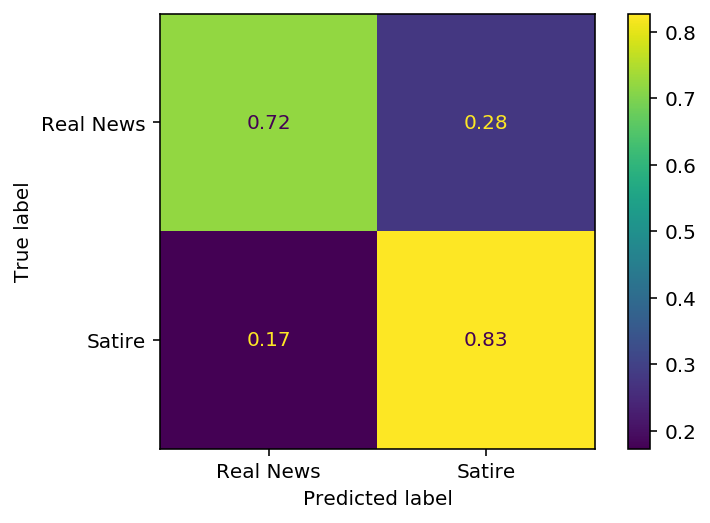

In [35]:
# Confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_train = confusion_matrix(y_val, y_pred_tfidf, normalize= 'true')

ConfusionMatrixDisplay(conf_matrix_train, display_labels = ['Real News', 'Satire']).plot();

This model has a higher rate of false positive compared to the old model (28% to 19%). The false negative result is consistent compared to the old model. Now I am going to pull out the most predictive words for each class.

In [36]:
# Pull out the most predictive words in legitimate articles

print('REAL NEWS PREDICTIVE WORDS:')
print(pd.DataFrame(logit_tfidf.coef_, columns = X_train_tfidf.columns).sum(axis = 0).sort_values(ascending = True).head(20))

REAL NEWS PREDICTIVE WORDS:
covid##       -5.333483
coronavirus   -4.094651
correction    -3.573890
dy            -3.428946
china         -2.825715
york          -2.807957
pandemic      -2.675641
lottery       -2.665577
ottawa        -2.660490
say           -2.659556
fashion       -2.568080
paris         -2.547663
art           -2.454712
brief         -2.376103
it’s          -2.365481
police        -2.285379
two           -2.251233
briefing      -2.208741
chief         -2.182903
china’s       -2.177635
dtype: float64


In [37]:
# Pull out the most predictive words in satires articles

print('SATIRES PREDICTIVE WORDS:')
print(pd.DataFrame(logit_tfidf.coef_, columns = X_train_tfidf.columns).sum(axis = 0).sort_values(ascending = False).head(20))

SATIRES PREDICTIVE WORDS:
man          5.812832
area         4.715363
local        4.329888
fuck         4.110298
nation       3.953800
tim          3.902718
harper       3.668033
nfl          3.535185
guy          3.446153
week         3.348476
nation’s     3.322657
friend       3.227626
realize      3.147230
shit         3.104137
clearly      3.097676
fan          3.091043
entire       3.072917
##yearold    2.980856
single       2.953348
reveals      2.793767
dtype: float64


The predictive words from each classes are quite similar to the earlier model's predictive words, sans the biased 'Onion' and 'horoscope' words. The predictive words in satire class is somewhat expected. A lot of satirical articles begin with 'Local Man' or 'Area Man', whereas these terminologies are rarely used by legitimate articles. Words relating to the pandemic appear to be predictive to the legitimate  articles. It is very interesting to see that satirical articles do not report on the pandemic (or at least in a significantly smaller amount). I guess it does make sense, as satires tend to 'get' at specific societal flaws, especially if it's related to politics or policies. It would be very interesting to pickle the best iteration of this model and use it to show the most predictive words in a custom sentence. Now I would like to know if I could tune the C value for this model to obtain a better model.

***

#### Tuning C values - Logit
<a id='cvals'></a>

I will re-run this model and try out a few different c-values to see if we could come up with a better model. I will be doing cross validation with this model and see which c value will give us the highest mean score. I will also create a plot to see any trend. I will change max_iter from 100 to 500 to allow for convergence.

In [39]:
# Loop and try out c-values

from sklearn.model_selection import cross_val_score

# Empty list for cross val scores

cvs = []

# Range of c values

C_range = np.array([.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000])

# Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(C=c, random_state=99, max_iter = 500)
    # Take the mean
    cv_score = np.mean(cross_val_score(LR_model, X_rem_tfidf, y_rem, cv = 6))
    cvs.append(cv_score)

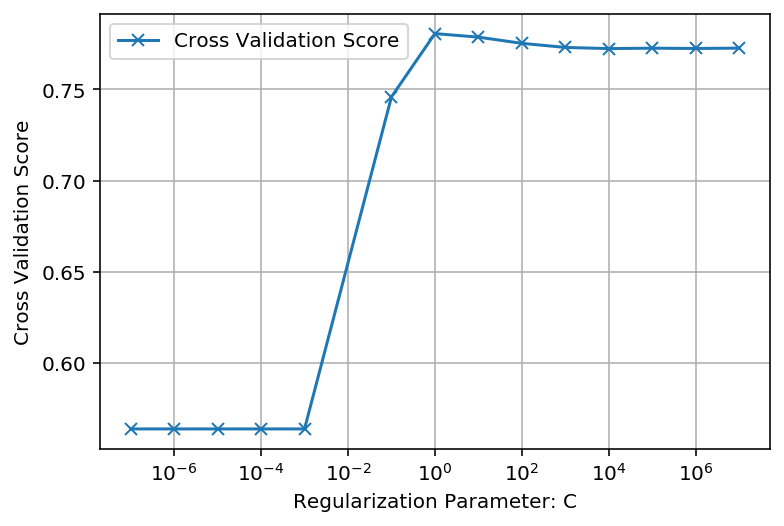

In [41]:
# Plot the CV scores

plt.figure()
plt.plot(C_range, cvs,label="Cross Validation Score",marker='x')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

In [107]:
# Find the highest CV score

print(f'The best model has C = {C_range[np.array(cvs).argmax()]}')

The best model has C = 1.0


Alas, after all fitting, the best number for c is the number we begun with. I think I will go ahead and pickle this model now, and since logit is one of the best models to pin point how predictions are made (especially in NLP), I would like to see if I could get the predictive power of each word in a sentence. Since I will not be modifying this model further, I will perform apply the test set on this model.

In [38]:
# Apply to test set

print(f'Score of test: {logit_tfidf.score(X_test_tfidf, y_test)}')

Score of test: 0.7708693149107657


The score for the test set is very similar to the validation set (78.1% vs 77%). 

***
#### Logistic pickling
<a id='pickle'></a>

Because I intend to pickle this model, I will create a pipeline that would vectorize a sentence and put the tokens into the trained logit. I will fit this pipeline to the remainder set of my data. As the vectorizer I chose to use TF-IDF with, again, my trusty tokenizer.

In [40]:
from sklearn.pipeline import make_pipeline

# Logistic pipeline:

logit_pipe = make_pipeline(tfidf, logit_tfidf)

In [41]:
# Fit pipe to remainder set

logit_pipe.fit(X_rem, y_rem)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=10, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                                 tokenizer=<function my_tokenizer at 0x7f867c868d40>,
                                 use_idf=True, vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    f

I will now put the test set into the pipe and see how it performs!

In [42]:
logit_pipe.score(X_test, y_test)

0.7731721358664364

Great! The result is ever so slightly better than before, I think this is because there is a larger train set for the model (using remainder as opposed to using the train set). I will now pickle the model. 🥒🥒

In [43]:
# pickle

import pickle

filename = 'logit.pkl'
pickle.dump(logit_pipe, open(filename, 'wb'))

In [44]:
# Load the pickle to test!

logit_load = pickle.load(open('logit.pkl', 'rb'))

Looking good! Now I will attempt to pass in a custom sentence and see if I could extract its probability for each class with predict_proba method.

In [48]:
# Try predict proba from the pickled file

logit_load.predict_proba(['Family outraged by Crown’s decision to downgrade charges in death of Anishinaabe woman in Thunder Bay'])

array([[0.42340365, 0.57659635]])

In [50]:
# Parse in the same sentence to the original pipe

logit_pipe.predict_proba(['Family outraged by Crown’s decision to downgrade charges in death of Anishinaabe woman in Thunder Bay'])

array([[0.42340365, 0.57659635]])

Both methods give the exact same results, indicating that the pickling works! I will now find a way to extract the most predictive words out of the sentence. From some online research, I found a code written by **Benjamin Bengfort** on github that I could modify to suit this problem.

Original code could be found at: https://gist.github.com/bbengfort/044682e76def583a12e6c09209c664a1

In [114]:
logit_pipe.named_steps

{'tfidfvectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=<function my_tokenizer at 0x7fe436886170>,
                 use_idf=True, vocabulary=None),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [63]:
from operator import itemgetter

def informative_features(model, text=None, n=20):

    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = logit_pipe.named_steps['tfidfvectorizer']
    classifier = model.named_steps['logisticregression']


    if text is not None:
        # Compute the coefficients for the text
        tvec = vectorizer.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=False)

    # Fold the results in half - top predictors are zipped together
    
    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append("Classified as: {}".format(model.predict_proba([text])))
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(cp, fnp, cn, fnn))

    return "\n".join(output)

In [64]:
print(informative_features(logit_pipe, 'CDC Coronavirus Testing Guidance Was Posted Against Scientists Objections'))

"CDC Coronavirus Testing Guidance Was Posted Against Scientists Objections"
Classified as: [[0.94216038 0.05783962]]

0.0000             ##    0.5621      scientist
0.0000            ###    0.5088           post
0.0000           ####    0.4681           test
0.0000          #####    0.4539    coronavirus
0.0000          ####s    0.0000              …
0.0000     ###million    0.0000             ’s
0.0000          ###th    0.0000            ’em
0.0000          ##ers    0.0000            ’##
0.0000      ##million    0.0000           ‘you
0.0000       ##minute    0.0000            ‘we
0.0000           ##th    0.0000          ‘this
0.0000         ##year    0.0000           ‘the
0.0000      ##yearold    0.0000          ‘star
0.0000              1    0.0000            ‘no
0.0000              2    0.0000           ‘new
0.0000             2’    0.0000          ‘just
0.0000              3    0.0000           ‘i’m
0.0000            3rd    0.0000          ‘it’s
0.0000              4    0.0000     

It's a great function, returning the predictive powers of each word. I would like to incorporate this into my API so the most important words would be highlighted. For now, I will move on to fit the SVC, Bayes, and the super-powered XGBoost.

***

#### PCA
<a id='pca'></a>

I will now create a scale and reduce pipeline as before. 

In [65]:
# Create pipeline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scale_pca_pipe = make_pipeline(StandardScaler(), PCA(n_components = 0.8))

In [66]:
# Fit the tfidf data to the pipeline

X_train_tfidf_scaled = scale_pca_pipe.fit_transform(X_train_tfidf)
X_val_tfidf_scaled = scale_pca_pipe.transform(X_val_tfidf)
X_rem_tfidf_scaled = scale_pca_pipe.transform(X_rem_tfidf)

***
#### SVM
<a id='svm'></a>

I will now fit a linear and rbf kernel SVM to the scaled and reduced data. I will use the default value.

In [34]:
# rbf kernel 

from sklearn.svm import SVC

# 1. Instantiate

svc = SVC()

# 2. Fit

svc.fit(X_train_tfidf_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
# Score train set

print(f'Train score: {svc.score(X_train_tfidf_scaled, y_train)}')

Train score: 0.9028256619868491


In [36]:
# Score val set

print(f'Validation score: {svc.score(X_val_tfidf_scaled, y_val)}')

Validation score: 0.776782858970259


The result for the rbf model is lower compared to the earlier rbf SVM model (78% vs 83%). Again, this is expected as we have removed the most predictive features. This model also appear to be slightly overfitted, with 90% training accuracy. I will now fit the linear SVM. Again, I will be using the default values.

In [37]:
from sklearn.svm import LinearSVC

# Instantiate

lin_svc = LinearSVC()

# Fit

lin_svc.fit(X_train_tfidf_scaled, y_train)

/Users/gabrielatanumihardja/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [38]:
# Score

print(f'Train score: {lin_svc.score(X_train_tfidf_scaled, y_train)}')

Train score: 0.7465789941354185


In [39]:
# Score

print(f'Validation score: {lin_svc.score(X_val_tfidf_scaled, y_val)}')

Validation score: 0.7204988807163415


The result for the linear SVM with the new dataset is also lower compared to the earlier linear SVM model (72% vs 78%). I expect that this decrease is due to the same reason that the rbf SVM's accuracy decreased. Next up, Bayes.

***

#### Multinomial Bayes
<a id='bae'></a>

I will now fit the new data to multinomial Bayes model. This model has been very popular with SPAM detection and other NLP classification models. Bayes models are very easy to understand and very transparent in the ways it classifies.

In [40]:
from sklearn.naive_bayes import MultinomialNB

In [41]:
# Instantiate

bayes = MultinomialNB()

# Fit

bayes.fit(X_train_tfidf, y_train)

# Score

print(f'training score: {bayes.score(X_train_tfidf, y_train)}')
print(f'val score: {bayes.score(X_val_tfidf, y_val)}')

training score: 0.7969077661275991
val score: 0.767188999040614


The results for this model is very good, at 77%, comparable to the logit model we have created.

***

#### XGBoost
<a id='xg'></a>
Next up, I will fit my dataset to the XGBoost model. It is a super-powered version of the a gradient boosting method. I will fit and score the new dataset on this model

In [70]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [74]:
# Instantiate

XGB_model = XGBClassifier(n_jobs = -1, verbosity= 2)

# Fit

XGB_model.fit(X_train_tfidf, y_train)

# Score

print(f'training score: {XGB_model.score(X_train_tfidf, y_train)}')
print(f'val score: {XGB_model.score(X_val_tfidf, y_val)}')

[17:58:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:10] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:14] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:27] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[17:59:32] INFO: src/tree/updater_prune.cc:74: tree prun

The results I'm getting with XGBoost is not very good. I believe hyperparameter tuning could help improve the scores, however I would like to try my hands on a deep learning model. I will abandon this model for now.

**Move on to notebook pt 6! Deep learning**